#  Solution for the generalized Schwefel optimization function

Th goal of this homework is to find the global minimum of the Schwefel objective function using ES algorithm with below parameters.

First of all, lets define Schwefel objective function:

> $ f(x_1 ... x_n) = \sum \limits _{i=1} ^{n} (-x_i \sin{(\sqrt{|x_i|})}) + \alpha . n $
> 
> $ x_i \in [-500, 500], i = 1, ..., n $
> 
> $ \alpha = 418.9829 $

The function has many local minimas. Its dimentionality is controlled by parameter $n$. The global minimum of Schwefel objective function with $n=2$ is:

> $ f(x^*) = 0 $
> 
> ,at
>
> $ x^* = (420.9687, … , 420.9687) $


## Evolution Strategy(ES)

Since we are dealing with a continous space, we will use ES as the type of all 4 evolutionary algorithms. The configuration will be set in a seperate configuration-file.

* real-valued representation
* adaptive mutation step control for each dimension
    * possible to enable or disable the adaptive mutation step control in configuration-file.
    * implemented as $d$ real values corresponding to the mutation rates of the n elements in x.
* appropriate reproduction operators
    * initialization
    * parent selection
    * reproduction
    * competition
    * termination
* experiment parameters
    * number of runs
    *  dimensionality of generalized Schwefel function (𝑛)
    * logging parameters
    

## Default Configuration
*	ES-type: only children will transfer to next generation | ($\mu$, $\lambda$)

* objective function dimension(N): 2

*	range of chromosome values(x-range): (-512, +512)

* number of parents selected for next generation($\mu$): 20

* population size($\lambda$): 100

* mutation: enabled

* mutation-type: type-1

*	mutation step-size($\sigma$): 0.15

*	recombination-type: type-1


## Defining Operators

Now, we will define each operator used in this algorithm:
* Reading config file:
    - In read-config-file function, the file in the given path is read and all required informations is exported.
    
* **Initializaion**:
    - In initilaization-function, based on dimension defined by user, an array of chromosomes of the population is created.


* **Parent selection**:
    - In this part, all chromosomes of the population are sorted ascending and the first $\mu$ chromosomes with least fitness value ( since we want to minimize our optimization function) are selected.


* **Recombination**:
    - In this function, only one child is created based on configuration selected. It can be either of the below 4 types:
     - type-1: Local intermidiary -> the child is the average of 2 fixed parents
     - type-2: global intermidiary -> each gene of child is the average of genes of 2 parents selected for each gene
     - type-3: Local discrete -> each gene of child is selected randomly from 2 fixed parents
     - type-4: global discrete -> each gene of child is selected from each 2 parents selected for each gene


* **Mutation**:
    - mutation is the most important operator of ES-algorithms.
    - it can be done in 3 diffrent ways which 2 of them is implemented here.
    - $\sigma$ is the mutation step size.
    - type-1:
        - $ \sigma^{'} = \sigma . \exp (\tau . N(0, 1)) $
        - $ x^{'} = x + N_i(0, \sigma^{'}) $
        - $ \tau = \frac {1} {\sqrt {n}} $
    
    - type-2:
        - $ \sigma_i^{'} = \sigma_i . \exp (\tau^{'} . N(0, 1) + \tau . N(0, 1)) $
        - $ x_i^{'} = x_i + \sigma^{'} . N(0, 1) $
        - $ \tau = \frac {1} {\sqrt {2n}} $
        - $ \tau^{'} = \frac {1} {\sqrt {2\sqrt {n}}} $

* **Survival Selection**:
    - Now, we have two choices to transfer chromosome to the next generation.
        - $(\mu , \lambda)$: Population of next generation is selected only from children.
        - $(\mu + \lambda)$: Population of next generation is selected from bothe children and parents.

In [1]:
# imports

import math
from math import isnan
from math import inf
import numpy as np
import random
from numpy.random import randn
from numpy.random import rand
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import logsumexp

## Plot Schwefel Function

Now, lets define Schwefel objective function and plot it to see its local minimas and global minimum point.

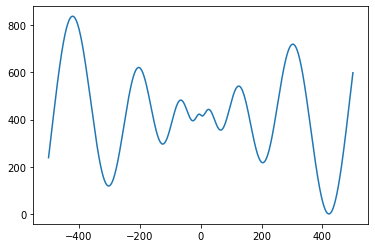

In [2]:
def Schwefel_fn(x):
    sum = 0
    dimension = len(x)
    alpha = 418.9829
    for x_i in x:
        sum += x_i * np.sin(np.sqrt(np.absolute(x_i)))
    return (alpha*dimension - sum)

def plot_2d(r_min=-500.0, r_max=500.0):
    # sample input range uniformly at 0.1 increments
    xaxis = np.arange(r_min, r_max, 0.1)
    # create a mesh from the axis
    x = np.meshgrid(xaxis)
    # compute targets
    results = Schwefel_fn(x)
    plt.plot(xaxis, results)
    # show the plot
    pyplot.show()

    
def plot_3d(r_min=-500.0, r_max=500.0):
    # sample input range uniformly at 0.1 increments
    xaxis = np.arange(r_min, r_max, 0.1)
    # create a mesh from the axis
    x = np.meshgrid(xaxis, xaxis)
    # compute targets
    results = Schwefel_fn(x)
    # create a surface plot with the jet color scheme
    figure = pyplot.figure()
    axis = figure.gca(projection='3d')
    axis.plot_surface(xaxis, xaxis, results, cmap='jet')
    # show the plot
    pyplot.show()

plot_2d()
# plot_3d()

In [104]:
class SchwefelFunctionES:
    def __init__(self, objective_fn, config_file_path=None):
        self.read_config_file(config_file_path)
        self.objective_fn = objective_fn
        self.epsilon = 1e-3
        # since our goal here is to find the minimum of the optimization function, the less the fitness is, the better the chromosome is.
        self.best_fitness = inf
        self.best_chromosome = None
                    
    def read_config_file(self, config_file_path):
        # default parameters
        if config_file_path == None:
            # self.es_type = '(mu,landa)'
            self.es_type = '(mu+landa)'

            self.scale_pop = 7
            self.max_iter = 25
            self.dimension = 3
            self.mu = 20                                      # number of parents selected
            self.landa = 100                                  # population size
            self.num_of_children = int(self.landa/self.mu)    # number of children generated by parents
            
            self.is_mutation_enabled = True
            self.mutation_rate = 80                           # mutation probability: 60%
            self.sigma_min = 0
            self.sigma_max = 1
            # self.mutation_type = 'type-1'
            # self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,1))

            # self.mutation_type = 'type-2'
            # self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,self.dimension))
            
            self.mutation_type = 'type-3'
            self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,self.dimension))
            self.k = int(self.dimension*(self.dimension-1)/2)
            self.min_alpha = math.radians(-180)
            self.max_alpha = math.radians(180)
            self.mutation_alpha = np.random.uniform(low=self.min_alpha, high=self.max_alpha, size=(self.landa,self.k))
            self.C_matrix = None

            # self.recombination_type = 'type-1'
            self.recombination_rate = 100                     # cross over probability: 100
            # self.recombination_type = 'type-2'
            # self.recombination_type = 'type-3'
            self.recombination_type = 'type-4'
            
            # create same bounds for all dimensions
            self.xi_min = -500.0
            self.xi_max = 500.0
            self.boundaries = np.array([[self.xi_min, self.xi_max] for i in range(self.dimension)])

        # read from configuration file
        else:
            settings = []
            with open(config_file_path,'r') as f:
                for line in f:
                    settings.append(line.split()[1])
            
            self.es_type = settings[0]
            self.max_iter = int(settings[1])
            self.dimension = int(settings[2])
            self.mu = int(settings[3])
            self.landa = int(settings[4])
            self.num_of_children = int(self.landa/self.mu)    # number of children generated by parents
            self.is_mutation_enabled = True if settings[5]=="True" else False
            self.mutation_type = settings[6]
            self.sigma_min = 0
            self.sigma_max = 1
            
            if self.mutation_type == 'type-1':
                self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,1))

            if self.mutation_type == 'type-2':
                self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,self.dimension))
            
            if self.mutation_type == 'type-3':
                self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(self.landa,self.dimension))
                self.k = int(self.dimension*(self.dimension-1)/2)
                self.min_alpha = math.radians(-180)
                self.max_alpha = math.radians(180)
                self.mutation_alpha = np.random.uniform(low=self.min_alpha, high=self.max_alpha, size=(self.landa,self.k))
                self.C_matrix = None

            self.recombination_type = settings[7]
            self.xi_min = int(settings[8])
            self.xi_max = int(settings[9])
            # create same bounds for all dimensions
            self.boundaries = np.array([[self.xi_min, self.xi_max] for i in range(self.dimension)])
            
            self.recombination_rate = int(settings[10])
            self.mutation_rate = int(settings[11])
            self.scale_pop = int(settings[12])
            
    def print_es_configuration(self):
        print( "*******************************")
        print(f'******   ES-{self.es_type}   ******')
        print( "*******************************")
        print(f'Schwefel dimension  : {self.dimension}')
        print(f'x_min , x_max       : {self.xi_min}, {self.xi_max}')
        print(f'number of iterations: {self.max_iter}')
        print(f'population size     : {self.landa}')
        if self.is_mutation_enabled == True:
            print("mutation             : enabled")
            print(f'mutation rate        : {self.mutation_rate}')
            print(f'mutation type       : {self.mutation_type}')
            # print(f'mutation step size  : {self.mutation_step_size}')
        elif self.is_mutation_enabled == False:
            print("mutation             : disabled")
        
        print(f'recombination type  : {self.recombination_type}')
        print(f'recombination rate  : {self.recombination_rate}')
        print( "*******************************")
        print( "*******************************")
        print("\n\n")
        
    def is_chrom_valid(self, chrom):
        """
        check if each value of the chromosome is inside the valid boundary or not
        """
        for d in range(self.dimension):
            min = self.boundaries[d][0]
            max = self.boundaries[d][1]
            if chrom[d] < min or chrom[d] > max:
                return False
        return True
       
    def initialize_population(self):
        """
        self.population = []
        for i in range(self.landa):
            # create a new chromosome randomly
            new_chrom = self.boundaries[:, 0] + rand(self.dimension) * (self.boundaries[:, 1] - self.boundaries[:, 0])
            while self.is_chrom_valid(new_chrom) == False:
                new_chrom = self.boundaries[:, 0] + rand(self.dimension) * (self.boundaries[:, 1] - self.boundaries[:, 0])
            self.population.append(new_chrom)
        self.population = np.array(self.population)
        return self.population
        """
        self.population = []
        for i in range(self.landa):
            tmp = []
            for i in range(self.dimension):
                tmp.append(random.uniform(self.xi_min, self.xi_max))
            self.population.append(tmp)
        self.population = np.array(self.population)
        return self.population
    
    def find_best_chromosome(self):
        """
        select best chromosome and best fitness value of the population
        sort all fitness values ascending and select the first mu chromosomes with lowest fitness
        (since we want to minimize the optimization function)
        """
        self.fitness_values = [(chrom, self.objective_fn(chrom)) for chrom in self.population]
        # sort fitness values ascending because we want to find the minimum of the function
        self.fitness_values.sort(key=lambda x: x[1])
        self.best_chromosome = self.fitness_values[0][0]
        self.best_fitness = self.fitness_values[0][1]
        return self.best_chromosome, self.best_fitness

    def parent_selection(self):
        # select 2 parents randomly
        # these parents are used to create one child
        self.selected_parents = []
        for i in range(2):
            random_index = np.random.randint(0, len(self.population)-1)
            self.selected_parents.append(self.population[random_index])
        self.selected_parents = np.array(self.selected_parents)
        return self.selected_parents
    
    def create_one_child(self):
        # create one child
        # type-1: Local intermidiary
        # type-2: global intermidiary
        # type-3: Local discrete
        # type-4: global discrete
        self.parents_to_add_to_population = []
        if self.recombination_type == 'type-1':
            self.parent_selection()
            self.parents_to_add_to_population.append(self.selected_parents[0])
            self.parents_to_add_to_population.append(self.selected_parents[1])
            new_child = np.mean(self.selected_parents, axis=0)
            
        elif self.recombination_type == 'type-2':
            # number of selected parents is equal to dimension
            new_child = []
            for i in range(self.dimension):
                self.parent_selection()
                self.parents_to_add_to_population.append(self.selected_parents[0])
                self.parents_to_add_to_population.append(self.selected_parents[1])
                new_child.append((self.selected_parents[0][i] + self.selected_parents[1][i])/2)
            new_child = np.array(new_child)
        
        elif self.recombination_type == 'type-3':
            new_child = []
            self.parent_selection()
            self.parents_to_add_to_population.append(self.selected_parents[0])
            self.parents_to_add_to_population.append(self.selected_parents[1])
            for i in range(self.dimension):
                random_num = np.random.randint(0, 2)
                new_child.append(self.selected_parents[random_num][i])
            new_child = np.array(new_child)
            
        elif self.recombination_type == 'type-4':
            new_child = []
            for i in range(self.dimension):
                self.parent_selection()
                self.parents_to_add_to_population.append(self.selected_parents[0])
                self.parents_to_add_to_population.append(self.selected_parents[1])
                random_num = np.random.randint(0, 2)
                new_child.append(self.selected_parents[random_num][i])
            new_child = np.array(new_child)
            
        return new_child
    
    def recombination(self):
        self.children = []
        for i in range(self.landa*self.scale_pop):
            random_num = np.random.randint(0, 101)
            if random_num <= self.recombination_rate:
                tmp = self.create_one_child()
                if self.is_chrom_valid(tmp) == False:
                    tmp = self.create_one_child()
                self.children.append(tmp)

        # randomly initiate a sigma (fill self.mutation_step_size) for all child based on mutation type
        if self.mutation_type == 'type-1':
            self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(len(self.children),1))
        elif self.mutation_type == 'type-2':
            self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(len(self.children),self.dimension))
        elif self.mutation_type == 'type-3':
            self.mutation_step_size = np.random.uniform(low=self.sigma_min, high=self.sigma_max, size=(len(self.children),self.dimension))
            self.mutation_alpha = np.random.uniform(low=self.min_alpha, high=self.max_alpha, size=(len(self.children),self.k))

        self.children = np.array(self.children)
        return self.children

    # check if matrix A is positive-semidefinite
    def is_pos_def(self, A):
        return np.all(np.linalg.eigvals(A) > 0)

    # convert matrix to positive-semidefinite
    def get_near_psd(self, A):
        C = (A + A.T)/2
        eigval, eigvec = np.linalg.eig(C)
        eigval[eigval < 0] = 0

        return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

    def create_C_matrix(self, k, sigmas, alphas):
        # create lower triangle matrix of C
        c_lower_tri = np.zeros((self.dimension, self.dimension))
        indx = 0
        for i in range(self.dimension):
            for j in range(self.dimension):
                if i < j:
                    c_lower_tri[i][j] = (sigmas[i]**2 - sigmas[j]**2)*np.tan(2*alphas[indx])/2
                    indx += 1
        # create higher triangle matrix of C
        c_higher_tri = np.zeros((self.dimension, self.dimension))
        indx = 0
        for j in range(self.dimension):
            for i in range(self.dimension):
                if i > j:
                    c_lower_tri[i][j] = (sigmas[i]**2 - sigmas[j]**2)*np.tan(2*alphas[indx])/2
                    indx += 1
        # create diagonal matrx of sigma**2
        c_diagonal = np.diag([(x**2)/2 for x in sigmas])
        C_matrix = c_lower_tri + c_diagonal + c_higher_tri
        
#         if self.is_pos_def(C_matrix) == True:
#             return C_matrix
#         else:
#             return self.get_near_psd(C_matrix)
        return self.get_near_psd(C_matrix)
        
    def mutate_one_chrom(self, chromosome, sigma, alpha=None):
        # mutate one chromosome
        chrom = chromosome
        
        if self.mutation_type == 'type-1':
            # in this type, sigma is a number
            taw = 1/np.sqrt(self.dimension)                        # taw is the learning rate in this method
            new_sigma = sigma * np.exp(taw * random.gauss(0, 1))
            if (new_sigma < self.epsilon):
                new_sigma = self.epsilon
            rand_num = random.gauss(0, 1)
            for d_indx in range(self.dimension):
                chrom[d_indx] += new_sigma * rand_num
        
        if self.mutation_type == 'type-2':
            # in this type, sigma is an array
            taw = 1/np.sqrt(2*self.dimension)                       # taw is the learning rate in this method
            taw_prim = 1/np.sqrt((2*np.sqrt(self.dimension)))       # taw_primn is the learning rate in this method
            # here mutation_step_size is a d-dimensional array
            new_sigma = sigma
            rand_num = random.gauss(0, 1)
            for i in range(len(sigma)):
                new_sigma[i] = sigma[i] * np.exp(taw_prim*rand_num + taw*random.gauss(0, 1))
            for i in range(len(sigma)):
                if new_sigma[i] < self.epsilon:
                    new_sigma[i] = self.epsilon
            for d_indx in range(self.dimension):
                chrom[d_indx] += new_sigma[d_indx] * random.gauss(0, 1)
        
        if self.mutation_type == 'type-3':
            beta = math.radians(5)      # beta = 5 degree -> but since we are working with radians, lets convert it
            # update sigma
            taw = 1/np.sqrt(2*self.dimension)                       # taw is the learning rate in this method
            taw_prim = 1/np.sqrt((2*np.sqrt(self.dimension)))       # taw_primn is the learning rate in this method
            # here mutation_step_size is a d-dimensional array
            new_sigma = sigma
            rand_num = random.gauss(0, 1)
            for i in range(len(sigma)):
                new_sigma[i] = sigma[i] * np.exp(taw_prim*rand_num + taw*random.gauss(0, 1))
            for i in range(len(sigma)):
                if new_sigma[i] < self.epsilon:
                    new_sigma[i] = self.epsilon
            # update alpha
            new_alpha = alpha
            rand_num = random.gauss(0, 1)
            for i in range(len(sigma)):
                new_alpha[i] = alpha[i] + beta*rand_num
            for i in range(len(alpha)):
                if new_alpha[i] > math.radians(180):
                    new_alpha[i] = new_alpha[i] - 2*math.radians(180)*np.sign(new_alpha[i])
            # create c-matrix
            chrom_C_matrix = self.create_C_matrix(self.k, new_sigma, new_alpha)
            # update chromosome
            mean = np.zeros(chrom_C_matrix.shape[0])
            chrom = chrom + np.random.multivariate_normal(mean, chrom_C_matrix)

        return chrom

    def mutation(self):
        mutated = []
        for c_indx in range(len(self.children)):
            # print("c: ", c)
            c = self.children[c_indx]
            sigma = self.mutation_step_size[c_indx]
            alpha = None
            if self.mutation_type == 'type-3':
                alpha = self.mutation_alpha[c_indx]
            random_num = np.random.randint(0, 100)
            if random_num <= self.mutation_rate:
                tmp = self.mutate_one_chrom(c, sigma, alpha)
                while self.is_chrom_valid(tmp) == False:
                    tmp = self.mutate_one_chrom(c, sigma, alpha)
                mutated.append(tmp)
            else:
                mutated.append(c)
            # print("tmp: ", mutated[-1])
            # print("~.~.~.~")
        self.children = []      
        self.children = np.array(mutated)
        return self.children

    def survival_selection(self):
        
        # only select childs or childs+parents
        if self.es_type == '(mu,landa)':
            # select top landa of offsprings
            t = [(chrom, self.objective_fn(chrom)) for chrom in self.children]
            t.sort(key=lambda x: x[1])
            t = t[:self.landa]
            self.population = []
            for c in t:
                self.population.append(c[0])
            self.population = np.array(self.population)
        
        if self.es_type == '(mu+landa)':
            t = []
            for c in self.children:
                t.append(c)
            for c in self.population:
                t.append(c)
            t1 = [(chrom, self.objective_fn(chrom)) for chrom in t]
            t1.sort(key=lambda x: x[1])
            t1 = t1[:self.landa]
            self.population = []
            for c in t1:
                self.population.append(c[0])
            self.population = np.array(self.population)
        
        return self.population

    def es_main_loop(self):
        self.print_es_configuration()
        self.initialize_population()
        for epoch in range(self.max_iter+1):
            self.find_best_chromosome()
            self.recombination()
            if self.is_mutation_enabled == True:
                self.mutation()
            self.survival_selection()
            if epoch%5 == 0:
                print(f'epoch: {epoch} | best chrom: {np.round(self.best_chromosome, 2)} | \
                        best fitness: {np.round(self.best_fitness, 5)}')
                          
        return self.best_chromosome, self.best_fitness

## Results

In [106]:
model = SchwefelFunctionES(objective_fn=Schwefel_fn, config_file_path=None)
# model = SchwefelFunctionES(objective_fn=Schwefel_fn, config_file_path="config.txt")

_, _ = model.es_main_loop()

*******************************
******   ES-(mu,landa)   ******
*******************************
Schwefel dimension  : 3
x_min , x_max       : -500, 500
number of iterations: 25
population size     : 100
mutation             : enabled
mutation rate        : 60
mutation type       : type-3
recombination type  : type-4
recombination rate  : 100
*******************************
*******************************



epoch: 0 | best chrom: [220.15 441.56 436.61] |                         best fitness: 334.11258
epoch: 5 | best chrom: [416.23 430.65 411.65] |                         best fitness: 25.52433
epoch: 10 | best chrom: [419.16 426.1  418.96] |                         best fitness: 4.24545
epoch: 15 | best chrom: [420.84 421.07 421.05] |                         best fitness: 0.00439
epoch: 20 | best chrom: [420.97 420.96 420.99] |                         best fitness: 0.00012
epoch: 25 | best chrom: [420.97 420.96 420.97] |                         best fitness: 4e-05
